# Finding Pairs
Inspired by Jonathan Larkin's Notebook:
https://www.quantopian.com/posts/pairs-trading-with-machine-learning

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [89]:
study_date = "2020-05-23"

## Define Universe
Select stocks to perform our search

In [90]:
universe = Q500US()

## Select Data Columns
We can choose from a variety of fundamental indicators provided by morningstar to help us when looking for pair relationships. The original article suggests using market cap, industry group and financial health. It is important to experiment with different selections of attributes.

Docs: https://www.quantopian.com/docs/data-reference/morningstar_fundamentals

In [91]:
# creating pipeline object that loads the selected data
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

In [92]:
# function to load a pandas df with data within selected dates
df = run_pipeline(pipe, study_date, study_date)
df.index = df.index.droplevel(0)  # drop the single date from the multi-index
df.head()

,Financial Health,Industry,Market Cap
Equity(2 [HWM]),C,10106,4
Equity(24 [AAPL]),A,31167,4
Equity(62 [ABT]),A,20639,4
Equity(67 [ADSK]),B,31165,4
Equity(88 [ACI]),D,10104,3


In [93]:
print("Number of selected equities: %s" % df.shape[0])

Number of selected equities: 499


### Cleaning data
This will vary with the data selected, here I apply the transformations specified in the original notebook

In [94]:
# remove stocks in Industry "Conglomerates"
df = df[df['Industry']!=31055]


# remove stocks without a Financial Health grade
df = df[df['Financial Health']!= None]

# replace the categorical data with numerical scores per the docs
df['Financial Health'] = df['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
df = df.replace({'Financial Health': health_dict})

In [95]:
df.describe()

,Financial Health,Industry,Market Cap
count,494.000000,494.000000,494.000000
mean,0.396761,21193.700405,3.931174
std,0.264670,9118.893855,0.268947
min,0.100000,10101.000000,2.000000
25%,0.100000,10320.000000,4.000000
50%,0.300000,20638.000000,4.000000
75%,0.700000,31054.000000,4.000000
max,0.900000,31169.000000,4.000000


## Defining Daily Data
So far we have fundamental data with respect to the date of our study. Now we need to select the time series data that will allow us to find clusters of equities that are hopefully cointegrated. Here I follow the original notebook's procedure to calculate the daily returns.

In [96]:
# function to get daily prices for each symbol from 2 years back up to the date of study.
pricing = get_pricing(
    symbols=df.index,
    fields='close_price',
    start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(study_date)
)

In [97]:
returns = pricing.pct_change()

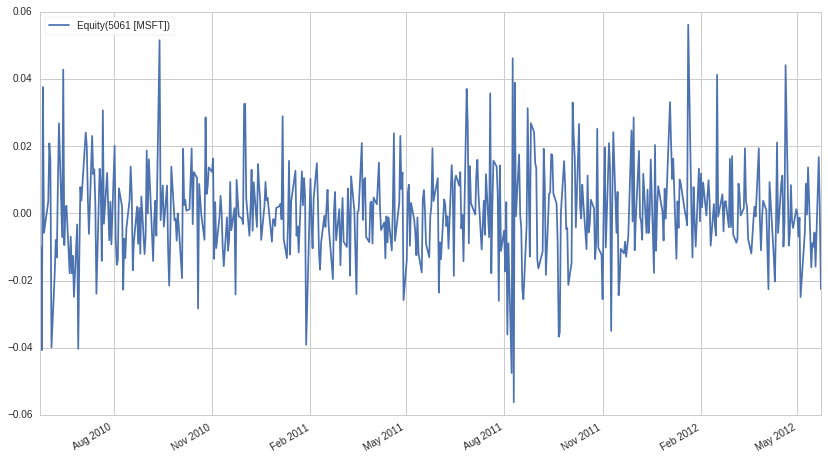

In [98]:
# plotting returns for a specific stock
returns[symbols(["MSFT"])].plot()
plt.show()

In [99]:
# we can only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)
print(returns.shape)

(505, 483)


## Finding Pairs
DBSCAN clustering: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

We also apply PCA for dimensionality reduction

In [100]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [101]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


PCA(copy=True, n_components=50, whiten=False)

Defining our variables

In [102]:
X = np.hstack(
    (pca.components_.T,
     df['Market Cap'][returns.columns].values[:, np.newaxis],
     df['Financial Health'][returns.columns].values[:, np.newaxis])
)

Run DBSCAN

In [103]:
clf = DBSCAN(eps=1.9, min_samples=3)
clf.fit(X)

/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

In [104]:
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_


Clusters discovered: 1


In [105]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [106]:
clustered_series.value_counts()

0    483
dtype: int64